# Modeling

In this section we propose a capsule in which three types of E.colis consuming ammonia, hydrogen sulfide and producing mycrene compete with each other and bacteria in the intestine. This is because they take up a similar niche with bacteria in the intestine environment. Consequently, some of our engineered E.colis may become extinct during competition after introduction, leading to the loss of the function of our product. 

## Preliminaries

We are inspired by the general logistic growth model, widely used to describe the population growth in biology, because it depicts the growth accurately in previously study. In our data, the growth curve is decided by the growth rate without inhibition and inhibition rate. The inhibition rate here refers to many inhibitive factors, such as the inhibition of the environment, the inhibition of population density, the inhibition of other bacteria... With the increase of the total population, the inhibition rate increase meanwhile, slowing down the marginal growth rate. When the inhibition rate is same as growth rate, meaning the marginal growth rate is equal to zero, the population reaches the highest capacity. 

Here are some basic assumptions of our model. First, assuming no other bacteria in the intestine, this model only considers competition among three engineered E.coli. Second, the growth rate of our E.coli in intestine is same as the data tested in vivo with lax anaerobic control due to technical limitation. Third, the environment of intestine--its pH value, temperature, humidity--is same to the LB medium we used in the experiment. Fourth, the growth rate of each E.coli would not be promoted or inhibited by the specific substances secreted by other bacteria or intestine itself. Fifth, the total population capacity of the bacteria in intestine keeps the same. Sixth, all our E.colis and nutrients distribute evenly in intestine and would not be excreted outside body during a certain period of time. 

Therefore, by looking out for the growth rate of each single E.coli, and their respective inhibition rate, we can then calculate and draw curves of concentrations rate and finally find the real-time ratio of each E.coli. Fortunately, with the best-fit logistic curve of population growth of each E.coli, we can calculate the growth rate and inhibition rate of each E.coli. 

Based on our experimental results, we trained a logistic regression model that predicts concentration  based on time. 

$$
\frac {dA} {dt} = kP(1-\frac{P}{N_m})
$$
taking the integral, we get
$$
A(t) = \frac{N_m}{1+\frac{N_m-P_0}{P_0} \cdot e^{-kt}} = \frac{N_m}{1+a \cdot e^{-kt}}
$$

Here, noted that $P_0$ can be trivial, we denote $\frac{N_m-P_0}{P_0}$ as an extra parameter $a$. 

In order to elongate the effective time as long as possible, we optimize our model with the following objectives,
* a simple logistic regression model, with parameters $a$, $k$ and $N_m$,  that maps a certain time to the corresponding population concentration that also takes into account the extinct ones. 
* display of the real-time ratio among three  three engineered E.coli that maximizes the minimum effective time among them.

In [194]:
# from __future__ import muli
import itertools
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
plt.style.use("tableau-colorblind10")
import pandas as pd
from scipy import integrate
from tqdm import tqdm
FS = (8, 4)

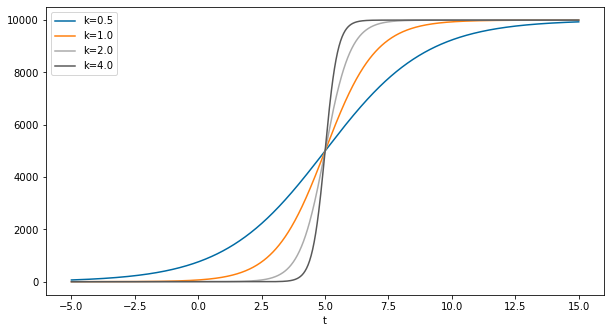

In [5]:
# Some typical logistic curves
t = np.linspace(-5, 15, 1000)

fig = plt.figure(figsize=(10, 18))

ax = fig.add_subplot(3, 1, 1)
t0, L = 5., 10000.
for k in [0.5,1.,2.,4.]:
    D = L / (1. + np.exp(-k * (t - t0)))
    _ = plt.plot(t, D, label=f'k={k}')
_ = ax.legend()
_ = ax.set_xlabel('t')

## Data
Before training our model, we have to tidy up and pre-process our data. Here we use pandas.

In [6]:
df = pd.read_csv('experimental_results.csv')
df

,Cycle Nr.,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,Trial,0,637.9000,1275.7000,1913.5000,2551.3000,3189.4000,3827.2000,4465.1000,5102.8000,...,36999.2000,37637.1000,38275.0000,38912.9000,39550.9000,40188.8000,40826.6000,41464.5000,42102.4000,42740.3000
1,Temp. [°C],26.4,37.3000,37.4000,37.5000,37.2000,37.1000,37.5000,37.6000,37.2000,...,37.3000,37.7000,37.1000,37.5000,37.5000,37.2000,37.7000,37.1000,37.2000,37.6000
2,A01,0.045000002,0.0449,0.0452,0.0451,0.0459,0.0463,0.0476,0.0485,0.0498,...,0.8127,0.8032,0.8087,0.7994,0.8060,0.7975,0.7849,0.7939,0.7780,0.7924
3,A02,0.045899998,0.0459,0.0460,0.0464,0.0468,0.0476,0.0486,0.0496,0.0509,...,0.8858,0.8895,0.9066,0.9023,0.9309,0.9392,0.9300,0.9581,0.9345,0.9616
4,A03,0.045600001,0.0458,0.0461,0.0466,0.0471,0.0483,0.0502,0.0508,0.0523,...,0.7782,0.7730,0.7863,0.7877,0.7953,0.7901,0.7775,0.7842,0.7684,0.7794
5,A04,0.044599999,0.0448,0.0451,0.0453,0.0457,0.0462,0.0478,0.0483,0.0496,...,0.8160,0.8141,0.8176,0.8104,0.8172,0.8085,0.7979,0.8039,0.7900,0.8030
6,A05,0.044500001,0.0449,0.0455,0.0457,0.0459,0.0467,0.0484,0.0491,0.0511,...,0.9163,0.9056,0.9344,0.9267,0.9338,0.9434,0.9260,0.9494,0.9215,0.9427
7,A06,0.045699999,0.0459,0.0470,0.0476,0.0464,0.0474,0.0488,0.0496,0.0512,...,0.8082,0.8017,0.8100,0.8059,0.8210,0.8239,0.8162,0.8273,0.8120,0.8228
8,A07,0.0471,0.0481,0.0481,0.0480,0.0482,0.0485,0.0496,0.0501,0.0506,...,0.4180,0.4175,0.4294,0.4291,0.4394,0.4410,0.4398,0.4528,0.4471,0.4623
9,A08,0.0462,0.0474,0.0490,0.0484,0.0495,0.0493,0.0521,0.0529,0.0541,...,0.8316,0.7980,0.8750,0.8514,0.8851,0.8929,0.8690,0.9004,0.8711,0.9012


From the raw data, we observe that there exists 68 columns, for 68 recording period, and 39 groups of data, including 3 for the control groups. We notice that temperatures and cycle number should not taken account as features, nor should the control groups should be our training sets.

### Data Cleaning and EDA

To clean our data, we use `pandas` and list operations to remove some rows and indices. After cleaning, we end up with 36 groups of data. In every group of data, we have $68$ features, namely $68$ points of time, each labeled with a corresponding concentration rate. Since for every E.coli in every scenarios, there exist three groups of data and each points of time should be mapped to only one output, namely one concentration rate, we manually pair our groups in three for each scenarios, and calculate the respective average value as our training sets. 

In [7]:
df.columns = df.loc[0].values
df.drop(df.index[0:2],inplace=True)
df.drop(df.index[36:],inplace=True)
total = df.groupby('Trial').sum().max(axis=1)
all_sets = total.index.to_list()
all_data =  pd.DataFrame()
for set in all_sets:
    temp = df[df['Trial'] == set][df.columns[1:]].T.sum(axis=1)
#     temp.index = pd.to_datetime(temp.index)
    temp = temp.to_frame(set)
    all_data = pd.concat([all_data, temp], axis=1)
all_data['$argA^fbr$ <antibio>'] = all_data[['A01', 'B01','C01','A07', 'B07','C07']].mean(axis=1)
all_data['$cysE-mut$ <antibio>'] = all_data[['A02', 'B02','C02','A08', 'B08','C08']].mean(axis=1)
all_data['$myrcene$ <antibio>'] = all_data[['A03', 'B03','C03','A09', 'B09','C09']].mean(axis=1)
all_data['$argA^fbr$'] = all_data[['A04', 'B04','C04','A10', 'B10','C10']].mean(axis=1)
all_data['$cysE-mut$'] = all_data[['A05', 'B05','C05','A11', 'B11','C11']].mean(axis=1)
all_data['$myrcene$'] = all_data[['A06', 'B06','C06','A12', 'B12','C12']].mean(axis=1)
# all_data['avg11_antibio'] = all_data[['A07', 'B07','C07']].mean(axis=1)
# all_data['avg22_antibio'] = all_data[['A08', 'B08','C08']].mean(axis=1)
# all_data['avg33_antibio'] = all_data[[].mean(axis=1)
# all_data['avg44_antibio'] = all_data[[].mean(axis=1)
# all_data['avg55_antibio'] = all_data[[].mean(axis=1)
# all_data['avg66_antibio'] = all_data[[]].mean(axis=1)

Now our clean data is visualized as followed,

In [8]:
all_data

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,C09,C10,C11,C12,$argA^fbr$ <antibio>,$cysE-mut$ <antibio>,$myrcene$ <antibio>,$argA^fbr$,$cysE-mut$,$myrcene$
0,0.0450,0.0459,0.0456,0.0446,0.0445,0.0457,0.0471,0.0462,0.0463,0.0445,...,0.0515,0.0468,0.0470,0.0460,0.073117,0.047783,0.047433,0.047117,0.046033,0.046967
637.9,0.0449,0.0459,0.0458,0.0448,0.0449,0.0459,0.0481,0.0474,0.0464,0.0451,...,0.0517,0.0472,0.0473,0.0463,0.077183,0.048050,0.047417,0.047317,0.046433,0.047383
1275.7,0.0452,0.0460,0.0461,0.0451,0.0455,0.0470,0.0481,0.0490,0.0478,0.0457,...,0.0503,0.0473,0.0466,0.0461,0.078783,0.048250,0.048017,0.047367,0.046683,0.047700
1913.5,0.0451,0.0464,0.0466,0.0453,0.0457,0.0476,0.0480,0.0484,0.0472,0.0455,...,0.0539,0.0480,0.0476,0.0467,0.049050,0.048700,0.048550,0.047833,0.047167,0.048033
2551.3,0.0459,0.0468,0.0471,0.0457,0.0459,0.0464,0.0482,0.0495,0.0478,0.0457,...,0.0522,0.0474,0.0470,0.0464,0.049150,0.049017,0.048767,0.047767,0.047050,0.047983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40188.8,0.7975,0.9392,0.7901,0.8085,0.9434,0.8239,0.4410,0.8929,0.6297,0.4527,...,0.6560,0.7294,0.8325,0.7448,0.635283,0.928117,0.718817,0.785667,0.876267,0.779350
40826.6,0.7849,0.9300,0.7775,0.7979,0.9260,0.8162,0.4398,0.8690,0.6172,0.4484,...,0.6598,0.7273,0.8038,0.7334,0.632733,0.912383,0.710133,0.773083,0.853150,0.768233
41464.5,0.7939,0.9581,0.7842,0.8039,0.9494,0.8273,0.4528,0.9004,0.6345,0.4640,...,0.6582,0.7427,0.8421,0.7608,0.639683,0.932050,0.717383,0.804550,0.883783,0.783950
42102.4,0.7780,0.9345,0.7684,0.7900,0.9215,0.8120,0.4471,0.8711,0.6247,0.4548,...,0.6595,0.7418,0.8173,0.7418,0.630433,0.918200,0.707533,0.786550,0.869767,0.769083


We can also visualize some of our experimental as follows. After connecting all the data points, we see that, in general, the curves are in _S_ shape.

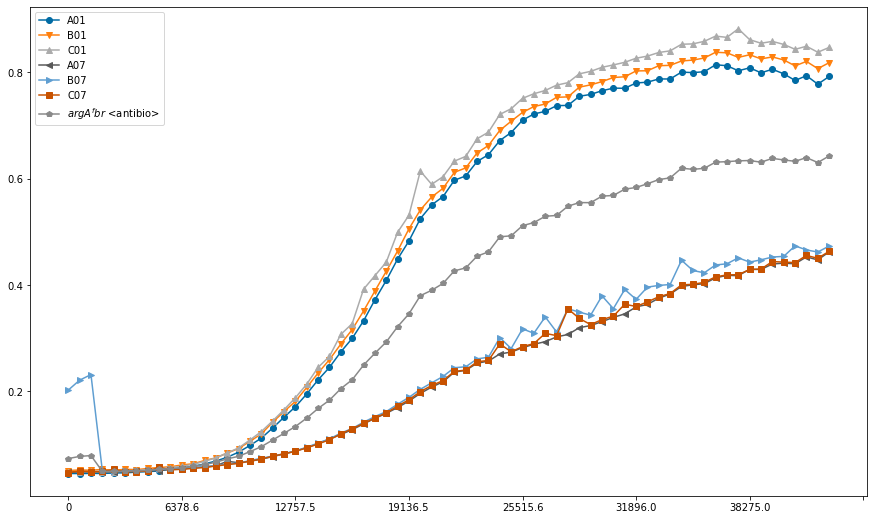

In [9]:
start = 0
ax = all_data[['A01', 'B01','C01','A07','B07','C07','$argA^fbr$ <antibio>']][start:].plot(style='-', figsize=(15,9))
markers = itertools.cycle(("o", "v", "^", "<", ">", "s", "p", "P", "*", "h", "X", "D", '.'))
for i, line in enumerate(ax.get_lines()):
    marker = next(markers)
    line.set_marker(marker)
_ = ax.legend()

## Nonlinear Least Squares for $argA^{fbr}$ with Antibacterial

When looking at the data, we only have the concentration rates per time period. We also have the formula that we want to apply, but we do not yet have the correct values of the parameters $a$, $k$ and $N_m$ in the formula.

Unfortunately, it is not possible to rewrite the Logistic Function as a Linear Regression, as was the case for the Exponential model. We will therefore need a more complex method: Nonlinear Least Squares estimation.

**Define the logistic function that has to be fitted.** First, we define the logistic function with input point of time $t$ and parameters $a$, $k$, $N_m$ and an offset to accommodate our model with the non-zero concentration rate at the begining.

In [10]:
def logistic(t, a, k, N_m, offset):
    return N_m / (1 + a * np.exp(-k*t)) + offset

**Random Initialization of parameters and upper, lower bounds set up.** Next, we use `np.random.random` to initialize our parameters, set up a relatively high bounds to let the model free. 

In [11]:
p0 = np.random.random(size=4)
bounds = (0., [100176.,3.,10019834.,10000.])

**Use SciPy's Curve Fit for Nonlinear Least Squares Estimation.**
In this step, Scipy does a Nonlinear Least Squares optimization, which minimizes the following lost function $\ell$,

$$
\ell(a,k,N_m,\textrm{offset}) = \sum_{i=0}^T \|r_i\|^2,
$$

where a residual \|r_i\|, the error distance matrix between ground-truth label concentraton rate and the predicted one, is given by,

$$
r_i = y^{true}_i - f(a,k,N_m,\textrm{offset}) 
$$
Here, $f$ is the logistic model to train.

In [12]:
import scipy.optimize as optim
x = np.array([float(x) for x in all_data.index])
y = np.array([float(x) for x in all_data['$argA^fbr$ <antibio>']])
(a,k,N_m,offset),cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
a,k,N_m,offset

(81.26780532272882,
 0.00022831184577454464,
 0.5963896243437306,
 0.03403317534035137)

**Plot the fitted function vs the real data.** As shown in the graph below, our Logistic model is very close to the ground truths.

Text(0, 0.5, 'Concentration')

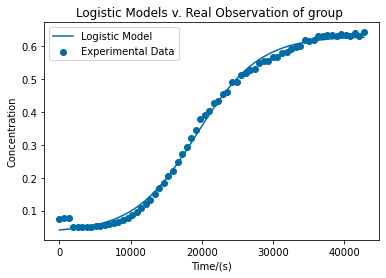

In [13]:
test_logistic = lambda t : N_m / (1 + a * np.exp(-k*t)) + offset
plt.scatter(x, y)
plt.plot(x, test_logistic(x))
plt.title('Logistic Models v. Real Observation of group $argA^fbr$ <antibio>')
plt.title('Logistic Models v. Real Observation of group ')
plt.legend(['Logistic Model','Experimental Data'])
plt.xlabel('Time/(s)')
plt.ylabel('Concentration')

## Nonlinear Least Squares for all cases

In this section, we apply the same training algorithm, as we did to $argA^{fbr}$ with antibacterial, to all $6$ scenrios. We also visualize all the fitted curves alongside our original data. We observe that none of the curves are obviously under-fitted.

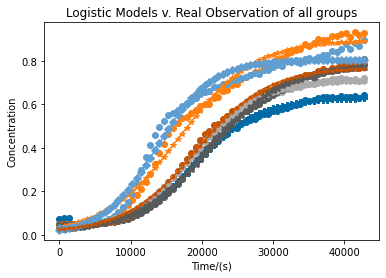

In [14]:
ret_data = {
    'group_name':[],
    'a':[],
    'k':[],
    'N_m':[],
    'offset':[],
    }
for group in all_data.columns[all_data.columns.get_loc('$argA^fbr$ <antibio>'):]:
    p0 = np.random.random(size=4)
    y = np.array([float(x) for x in all_data[group]])
    (a,k,N_m,offset),cov = optim.curve_fit(logistic, x, y, bounds=bounds, p0=p0)
    test_logistic = lambda t : N_m / (1 + a * np.exp(-k*t)) + offset
    plt.scatter(x, y)
    ret_data['group_name'].append(group)
    ret_data['a'].append(a)
    ret_data['k'].append(k)
    ret_data['N_m'].append(N_m)
    ret_data['offset'].append(offset)
    plt.plot(x, test_logistic(x),marker = next(markers))
    plt.title(f'Logistic Models v. Real Observation of all groups')
    plt.xlabel('Time/(s)')
    plt.ylabel('Concentration')

We also display all the trained parameters in a `pandas.DataFrame`.

In [15]:
output_df = pd.DataFrame(ret_data)
output_df.to_csv('./outputs/out.csv')
output_df

,group_name,a,k,N_m,offset
0,$argA^fbr$ <antibio>,81.267832,0.000228,0.596390,3.403322e-02
1,$cysE-mut$ <antibio>,24.231428,0.000189,0.897522,1.871706e-25
2,$myrcene$ <antibio>,60.918936,0.000218,0.693091,2.001466e-02
3,$argA^fbr$,56.760448,0.000191,0.771270,1.323637e-02
4,$cysE-mut$,35.515325,0.000261,0.805412,1.200743e-25
5,$myrcene$,48.169818,0.000201,0.761659,9.799155e-03


## Applying the Parameters into Three E.colis Coexisting Scenarios

Given the formula of derivatives of concentrations of the three crafted e.colis,

$$
\frac {dA}{dt} = k_A \cdot A (1 - \frac {A}{N_1} - \frac{k_B}{k_A} \cdot \frac{B}{N_2} - \frac{k_C}{k_A} \cdot \frac{C}{N_3}) = k_A \cdot A (1 - \frac {A}{N_1}) - \frac{k_B}{N_2} \cdot AB - \frac{k_C}{N_3} \cdot AC \\
\frac {dB}{dt} = k_B \cdot B (1 - \frac {B}{N_2} - \frac{k_A}{k_B} \cdot \frac{A}{N_1} - \frac{k_C}{k_B} \cdot \frac{C}{N_3}) = k_B \cdot B (1 - \frac {B}{N_2}) - \frac{k_A}{N_1} \cdot BA - \frac{k_C}{N_3} \cdot BC \\
\frac {dC}{dt} = k_C \cdot C (1 - \frac {C}{N_3} - \frac{k_A}{k_C} \cdot \frac{A}{N_1} - \frac{k_B}{k_C} \cdot \frac{B}{N_2}) = k_C \cdot C (1 - \frac {C}{N_3}) - \frac{k_A}{N_1} \cdot AC - \frac{k_B}{N_2} \cdot BC
$$

we plot the curve of growth rate and concentrations of three crafted
e.coli with and without the effect of antibacterial.

In [16]:
from scipy.integrate import odeint
from scipy.optimize import leastsq

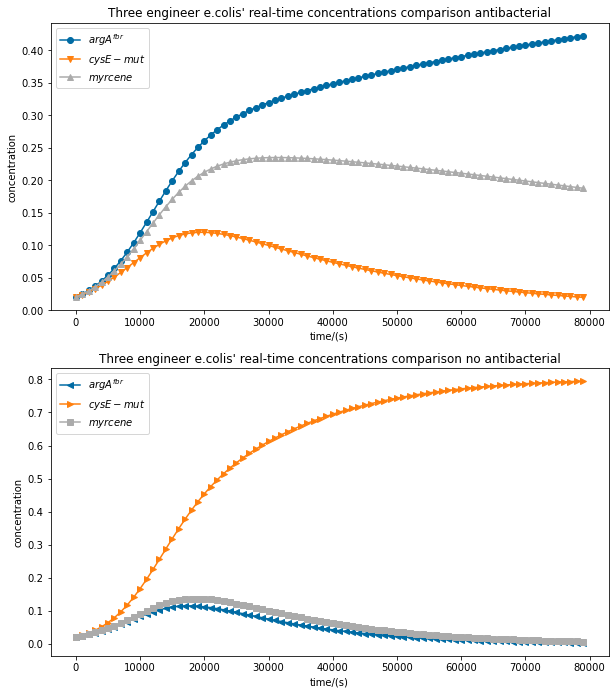

In [17]:
t = np.arange(0,80000,1000)

def deriv(w,t,ka,kb,kc,n1,n2,n3): 
    x,y,z = w
    return np.array([ka*(1-x/n1)*x-kb*y*x/n2-kc*x*z/n3,
                     kb*(1-y/n2)*y-ka*y*x/n1-kc*y*z/n3,
                     kc*(1-z/n3)*z-ka*z*x/n1-kb*y*z/n2])

fig = plt.figure(figsize=(10, 18))
plt.subplots_adjust(hspace=0.2)

ax1 = fig.add_subplot(3,1,1)
p = ret_data['k'][:3] + ret_data['N_m'][:3] + [0.02,0.02,0.02]
ka,kb,kc,n1,n2,n3,x0,y0,z0=p
yinit = np.array([x0,y0,z0]) # initial vals
yyy = odeint(deriv,yinit,t,args=(ka,kb,kc,n1,n2,n3))
ax1.plot(t,yyy[:,0],marker = next(markers),label="$argA^{fbr}$")
ax1.plot(t,yyy[:,1],marker = next(markers),label="$cysE-mut$")
ax1.plot(t,yyy[:,2],marker = next(markers),label="$myrcene$")
ax1.set_xlabel('time/(s)')
ax1.set_ylabel('concentration')
ax1.set_title('Three engineer e.colis\' real-time concentrations comparison antibacterial')
_ = ax1.legend(loc=2)


ax2 = fig.add_subplot(3,1,2)

p = ret_data['k'][3:] + ret_data['N_m'][3:] + [0.02,0.02,0.02]

ka,kb,kc,n1,n2,n3,x0,y0,z0=p
yinit = np.array([x0,y0,z0]) # initial vals
yyy = odeint(deriv,yinit,t,args=(ka,kb,kc,n1,n2,n3))
ax2.plot(t,yyy[:,0],marker = next(markers),label="$argA^{fbr}$")
ax2.plot(t,yyy[:,1],marker = next(markers),label="$cysE-mut$")
ax2.plot(t,yyy[:,2],marker = next(markers),label="$myrcene$")
ax2.set_xlabel('time/(s)')
ax2.set_ylabel('concentration')
ax2.set_title('Three engineer e.colis\' real-time concentrations comparison no antibacterial')
_ = ax2.legend(loc=2)

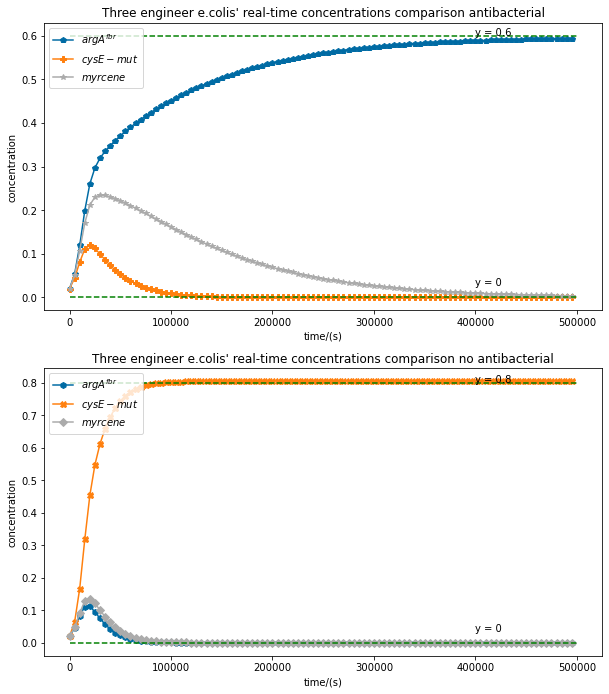

In [18]:
t = np.arange(0,500000,5000)

def deriv(w,t,ka,kb,kc,n1,n2,n3,offset1=0,offset2=0):
    x,y,z = w
    y+=offset1
    z+=offset2
    return np.array([ka*(1-x/n1)*x-kb*y*x/n2-kc*x*z/n3,
                     kb*(1-y/n2)*y-ka*y*x/n1-kc*y*z/n3,
                     kc*(1-z/n3)*z-ka*z*x/n1-kb*y*z/n2])

fig = plt.figure(figsize=(10, 18))
plt.subplots_adjust(hspace=0.2)

ax1 = fig.add_subplot(3,1,1)
p = ret_data['k'][:3] + ret_data['N_m'][:3] + [0.02,0.02,0.02]
ka,kb,kc,n1,n2,n3,x0,y0,z0=p
yinit = np.array([x0,y0,z0]) # initial vals
yyy1 = odeint(deriv,yinit,t,args=(ka,kb,kc,n1,n2,n3))
ax1.plot(t,yyy1[:,0],marker = next(markers),label="$argA^{fbr}$")
ax1.plot(t,yyy1[:,1],marker = next(markers),label="$cysE-mut$")
ax1.plot(t,yyy1[:,2],marker = next(markers),label="$myrcene$")
ax1.plot([0,500000],[0.6,0.6],"g--")
ax1.plot([0,500000],[0,0],"g--")
ax1.text(400000,0.6,'y = 0.6')
ax1.text(400000,0,'y = 0\n')
ax1.set_xlabel('time/(s)')
ax1.set_ylabel('concentration')
ax1.set_title('Three engineer e.colis\' real-time concentrations comparison antibacterial')
_ = ax1.legend(loc=2)


ax2 = fig.add_subplot(3,1,2)

p = ret_data['k'][3:] + ret_data['N_m'][3:] + [0.02,0.02,0.02]

ka,kb,kc,n1,n2,n3,x0,y0,z0=p
yinit = np.array([x0,y0,z0]) # initial vals
yyy2 = odeint(deriv,yinit,t,args=(ka,kb,kc,n1,n2,n3))
ax2.plot(t,yyy2[:,0],marker = next(markers),label="$argA^{fbr}$")
ax2.plot(t,yyy2[:,1],marker = next(markers),label="$cysE-mut$")
ax2.plot(t,yyy2[:,2],marker = next(markers),label="$myrcene$")
ax2.plot([0,500000],[0.8,0.8],"g--")
ax2.plot([0,500000],[0,0],"g--")
ax2.text(400000,0.8,'y = 0.8')
ax2.text(400000,0,'y = 0\n')
ax2.set_xlabel('time/(s)')
ax2.set_ylabel('concentration')
ax2.set_title('Three engineer e.colis\' real-time concentrations comparison no antibacterial')
_ = ax2.legend(loc=2)

In [147]:
from 

In [148]:
yyy1

array([[2.00000000e-02, 2.00000000e-02, 2.00000000e-02],
       [5.38249907e-02, 4.43143562e-02, 5.11295740e-02],
       [1.19040813e-01, 8.06894407e-02, 1.07416819e-01],
       [1.98989292e-01, 1.11047993e-01, 1.70566702e-01],
       [2.60464413e-01, 1.19671240e-01, 2.12080692e-01],
       [2.97077531e-01, 1.12375490e-01, 2.29779214e-01],
       [3.19249526e-01, 9.94242627e-02, 2.34562927e-01],
       [3.35017023e-01, 8.58992434e-02, 2.33821353e-01],
       [3.48011122e-01, 7.34642306e-02, 2.30727097e-01],
       [3.59629101e-01, 6.25025854e-02, 2.26489717e-01],
       [3.70391210e-01, 5.29985715e-02, 2.21586101e-01],
       [3.80501585e-01, 4.48250000e-02, 2.16235252e-01],
       [3.90053995e-01, 3.78310948e-02, 2.10563427e-01],
       [3.99103753e-01, 3.18691394e-02, 2.04659640e-01],
       [4.07692078e-01, 2.68026130e-02, 1.98594332e-01],
       [4.15854056e-01, 2.25084786e-02, 1.92425978e-01],
       [4.23621139e-01, 1.88774424e-02, 1.86203812e-01],
       [4.31021891e-01, 1.58133

In [19]:
THRESHOLD = 1
t = np.arange(0,500000,1)

def add_offset(params,threshold=THRESHOLD):
    o1,o2 = params
    def deriv(w,t,ka,kb,kc,n1,n2,n3,offset1=0,offset2=0):
        x,y,z = w
        y+=offset1
        z+=offset2
        return np.array([ka*(1-x/n1)*x-kb*y*x/n2-kc*x*z/n3,
                     kb*(1-y/n2)*y-ka*y*x/n1-kc*y*z/n3,
                     kc*(1-z/n3)*z-ka*z*x/n1-kb*y*z/n2])
    p = ret_data['k'][3:] + ret_data['N_m'][3:] + [0.02,0.02,0.02]
    ka,kb,kc,n1,n2,n3,x0,y0,z0=p
    yinit = np.array([x0,y0,z0])
    yyy = odeint(deriv,yinit,t,args=(ka,kb,kc,n1,n2,n3,o1,o2))
    for i in range(1,yyy.shape[0]):
        j = min(yyy[i])
        if j <= 0:
             return t[i]
             break

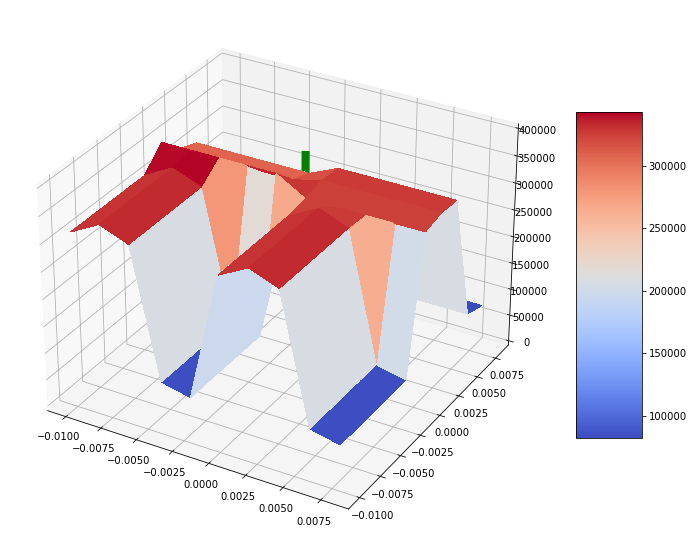

In [270]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
# ax.view_init(40, 0)
# X = np.arange(-0.01, 0.01, 0.002)
# Y = np.arange(-0.01, 0.01, 0.002)
# Z = np.array([add_offset(i) for i in tqdm(np.array(np.meshgrid(X, Y)).reshape(100,2))]).reshape(10,10)
# X, Y = np.meshgrid(X, Y)

#Plot the surface.

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.plot([0,0],[0,0],[0,400000],'g',linewidth=8)
# ax.scatter(0,0,add_offset((0.,0.)),s=1000,color='g', linewidth=0.5)
# # Customize the z axis.
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [259]:
X = np.arange(-0.01, 0.01, 0.002)
Y = np.arange(-0.01, 0.01, 0.002)
Z = np.array([add_offset(i) for i in tqdm(np.array(np.meshgrid(X, Y)).reshape(100,2))]).reshape(10,10)
X, Y = np.meshgrid(X, Y)

  2%|▏         | 2/100 [00:02<02:24,  1.47s/it]

KeyboardInterrupt: 

In [139]:
X = np.arange(-0.1, 0.1, 0.02)
Y = np.arange(-0.1, 0.1, 0.02)
Z = np.array([add_offset(i) for i in np.array(np.meshgrid(X, Y)).reshape(400,2)]).reshape(20,20)

array([-2.00000000e-01, -1.60000000e-01, -1.20000000e-01, -8.00000000e-02,
       -4.00000000e-02,  2.77555756e-17,  4.00000000e-02,  8.00000000e-02,
        1.20000000e-01,  1.60000000e-01])